<a href="https://colab.research.google.com/github/garthajon/QuantFinanceIntro/blob/main/QuantLiquidityEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-4221901259.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="1y", interval="1d")
[*********************100%***********************]  1 of 1 completed


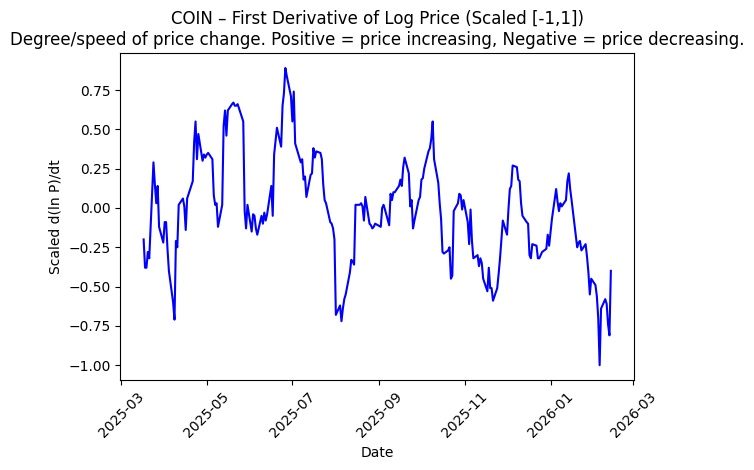

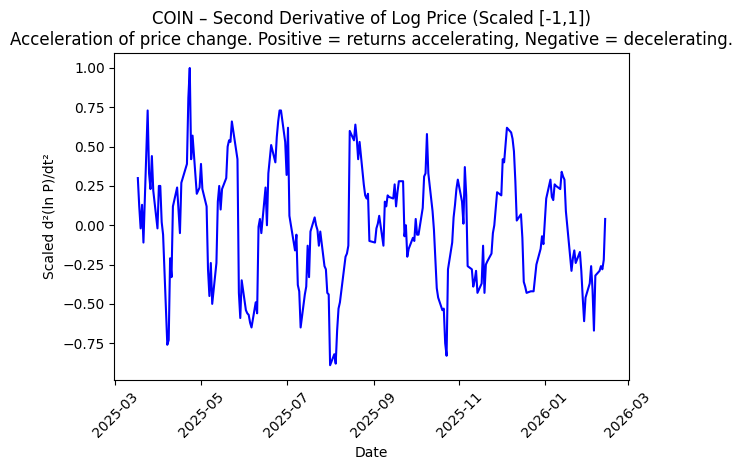

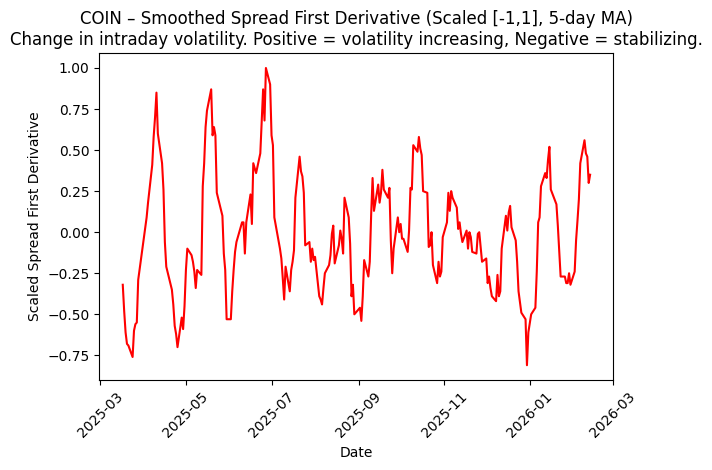

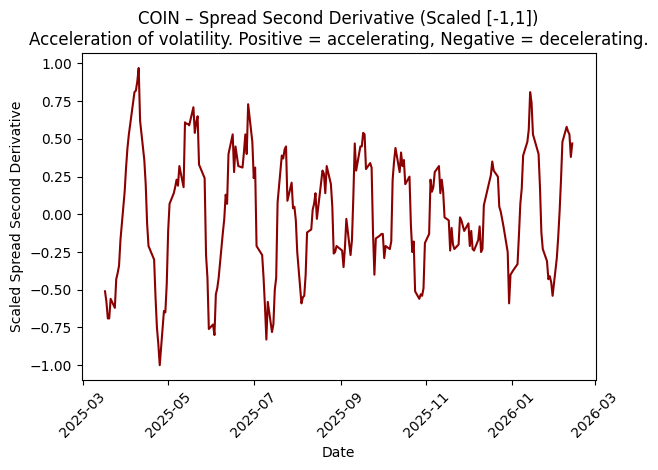

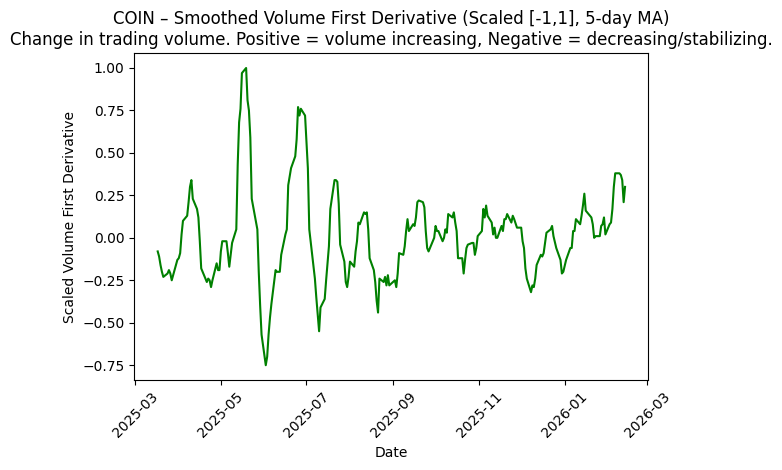

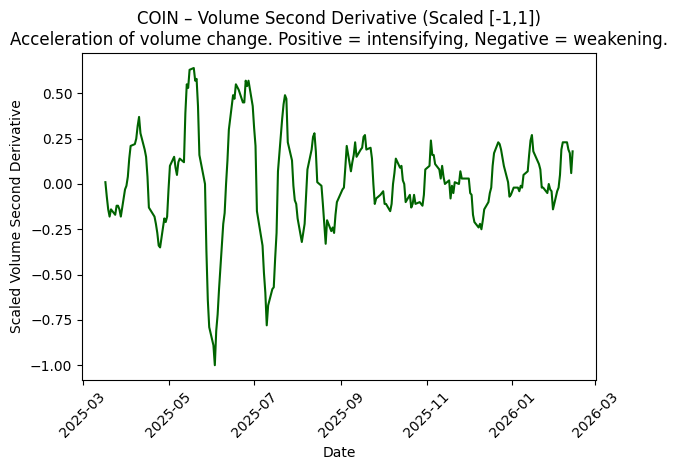

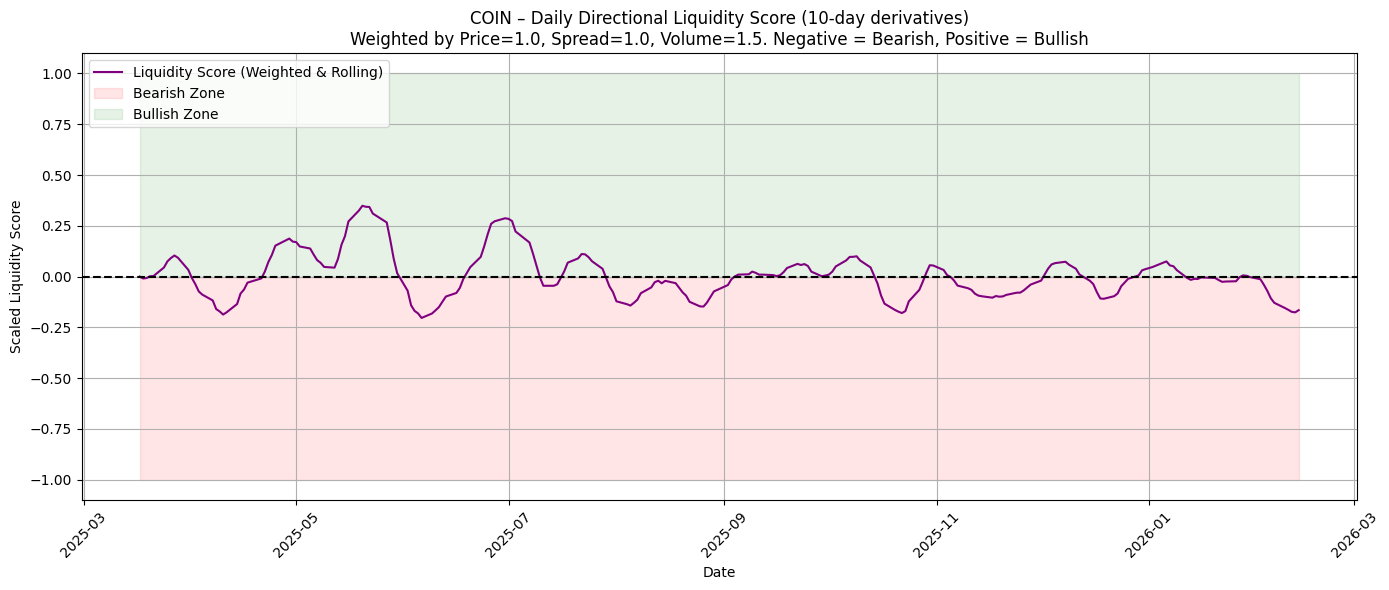


==== COIN TREND INFERENCE ====
Price: downward, trend stable
Volatility (spread): increasing, accelerating
Volume: increasing, accelerating
Directional Liquidity Score (Weighted & Rolling): -0.17 (Moderate bearish liquidity)



In [75]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# USER-ADJUSTABLE PARAMETERS
# ==========================================================
ticker = "COIN"           # Change to any stock ticker
delta_days = 10           # Derivative period in days
spread_ma_days = 5        # Smoothing window for spread first derivative
volume_ma_days = 5        # Smoothing window for volume first derivative
liquidity_rolling_days = 5 # Optional rolling mean for liquidity smoothing

# Weighting for liquidity calculation (0-1 scale, relative importance)
w_price = 1.0   # Weight for price derivative
w_spread = 1.0 # Weight for spread derivative
w_volume =1.5 # Weight for volume derivative

# ==========================================================
# DOWNLOAD DATA
# ==========================================================
data = yf.download(ticker, period="1y", interval="1d")
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data = data[~data.index.duplicated(keep="first")]
assert data.index.is_monotonic_increasing, "Time index is not ordered properly."

# ==========================================================
# LOG PRICE
# ==========================================================
data["log_price"] = np.log(data["Close"])

# ==========================================================
# TRUE TIME DIFFERENCE
# ==========================================================
dt = data.index.to_series().diff(delta_days).dt.days

# ==========================================================
# PRICE DERIVATIVES
# ==========================================================
data["first_derivative"] = data["log_price"].diff(delta_days) / dt
data["second_derivative"] = data["first_derivative"].diff(delta_days) / dt

# ==========================================================
# SPREAD DERIVATIVES (simplified)
# ==========================================================
data["spread"] = data["High"] - data["Low"]
data["log_spread"] = np.log(data["spread"])
data["spread_first_derivative"] = data["log_spread"].diff(delta_days) / dt
data["spread_first_derivative_smooth"] = data["spread_first_derivative"].rolling(
    window=spread_ma_days, min_periods=1
).mean()
data["spread_second_derivative"] = data["spread_first_derivative_smooth"].diff(delta_days) / dt

# ==========================================================
# VOLUME DERIVATIVES
# ==========================================================
data["volume_log"] = np.log(data["Volume"] + 1)
data["volume_first_derivative"] = data["volume_log"].diff(delta_days) / dt
data["volume_first_derivative_smooth"] = data["volume_first_derivative"].rolling(
    window=volume_ma_days, min_periods=1
).mean()
data["volume_second_derivative"] = data["volume_first_derivative_smooth"].diff(delta_days) / dt

# ==========================================================
# DROP NA VALUES
# ==========================================================
data = data.dropna()

# ==========================================================
# STANDARDIZE ALL METRICS TO [-1,1]
# ==========================================================
def standardize_series(series):
    max_abs = series.abs().max()
    if max_abs == 0:
        return series
    return np.round(series / max_abs, 2)

data["first_derivative_scaled"] = standardize_series(data["first_derivative"])
data["second_derivative_scaled"] = standardize_series(data["second_derivative"])
data["spread_first_derivative_scaled"] = standardize_series(data["spread_first_derivative_smooth"])
data["spread_second_derivative_scaled"] = standardize_series(data["spread_second_derivative"])
data["volume_first_derivative_scaled"] = standardize_series(data["volume_first_derivative_smooth"])
data["volume_second_derivative_scaled"] = standardize_series(data["volume_second_derivative"])

# ==========================================================
# PLOTTING FUNCTION WITH NARRATIVE
# ==========================================================
def plot_metric(series, title, ylabel, narrative, color='blue'):
    plt.figure()
    plt.plot(data.index, series, color=color)
    plt.title(f"{title}\n{narrative}")
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ==========================================================
# INDIVIDUAL METRIC PLOTS
# ==========================================================
plot_metric(
    data["first_derivative_scaled"],
    f"{ticker} – First Derivative of Log Price (Scaled [-1,1])",
    "Scaled d(ln P)/dt",
    "Degree/speed of price change. Positive = price increasing, Negative = price decreasing."
)

plot_metric(
    data["second_derivative_scaled"],
    f"{ticker} – Second Derivative of Log Price (Scaled [-1,1])",
    "Scaled d²(ln P)/dt²",
    "Acceleration of price change. Positive = returns accelerating, Negative = decelerating."
)

plot_metric(
    data["spread_first_derivative_scaled"],
    f"{ticker} – Smoothed Spread First Derivative (Scaled [-1,1], {spread_ma_days}-day MA)",
    "Scaled Spread First Derivative",
    "Change in intraday volatility. Positive = volatility increasing, Negative = stabilizing.",
    color="red"
)

plot_metric(
    data["spread_second_derivative_scaled"],
    f"{ticker} – Spread Second Derivative (Scaled [-1,1])",
    "Scaled Spread Second Derivative",
    "Acceleration of volatility. Positive = accelerating, Negative = decelerating.",
    color="darkred"
)

plot_metric(
    data["volume_first_derivative_scaled"],
    f"{ticker} – Smoothed Volume First Derivative (Scaled [-1,1], {volume_ma_days}-day MA)",
    "Scaled Volume First Derivative",
    "Change in trading volume. Positive = volume increasing, Negative = decreasing/stabilizing.",
    color="green"
)

plot_metric(
    data["volume_second_derivative_scaled"],
    f"{ticker} – Volume Second Derivative (Scaled [-1,1])",
    "Scaled Volume Second Derivative",
    "Acceleration of volume change. Positive = intensifying, Negative = weakening.",
    color="darkgreen"
)

# ==========================================================
# DAILY DIRECTIONAL LIQUIDITY SCORE CALCULATION (WEIGHTED)
# ==========================================================
# Weighted liquidity: scale 0–1 each metric weight
data["directional_liquidity_score"] = (
    w_price * data["first_derivative_scaled"] -
    w_spread * data["spread_first_derivative_scaled"] +
    w_volume * data["volume_first_derivative_scaled"]
) / (w_price + w_spread + w_volume)

# Optional rolling mean for smoothing
data["directional_liquidity_rolling"] = data["directional_liquidity_score"].rolling(
    window=liquidity_rolling_days, min_periods=1
).mean()

# ==========================================================
# LIQUIDITY SCORE HISTORY PLOT
# ==========================================================
plt.figure(figsize=(14,6))
plt.plot(data.index, data["directional_liquidity_rolling"], color="purple", label="Liquidity Score (Weighted & Rolling)")
plt.axhline(0, color="black", linestyle="--")
plt.fill_between(data.index, -1, 0, color='red', alpha=0.1, label="Bearish Zone")
plt.fill_between(data.index, 0, 1, color='green', alpha=0.1, label="Bullish Zone")
plt.title(f"{ticker} – Daily Directional Liquidity Score ({delta_days}-day derivatives)\nWeighted by Price={w_price}, Spread={w_spread}, Volume={w_volume}. Negative = Bearish, Positive = Bullish")
plt.xlabel("Date")
plt.ylabel("Scaled Liquidity Score")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ==========================================================
# TREND INFERENCE FUNCTION (SCALAR SAFE)
# ==========================================================
def infer_trend(data, ticker):
    latest = data.iloc[-1]

    # Convert any single-element Series to scalar
    def to_scalar(x):
        if isinstance(x, pd.Series):
            return x.item()
        return x

    price_fd = to_scalar(latest["first_derivative_scaled"])
    price_sd = to_scalar(latest["second_derivative_scaled"])
    spread_fd = to_scalar(latest["spread_first_derivative_scaled"])
    spread_sd = to_scalar(latest["spread_second_derivative_scaled"])
    volume_fd = to_scalar(latest["volume_first_derivative_scaled"])
    volume_sd = to_scalar(latest["volume_second_derivative_scaled"])
    liquidity_score = to_scalar(latest["directional_liquidity_rolling"])

    # PRICE
    price_trend = "upward" if price_fd > 0 else "downward"
    price_stability = "stable" if abs(price_sd) < 0.1 else "changing"

    # SPREAD
    spread_trend = "increasing" if spread_fd > 0 else "decreasing"
    spread_accel = "accelerating" if spread_sd > 0 else "decelerating"

    # VOLUME
    volume_trend = "increasing" if volume_fd > 0 else "decreasing"
    volume_accel = "accelerating" if volume_sd > 0 else "decelerating"

    # LIQUIDITY
    if liquidity_score > 0.5:
        liquidity_note = "Strong bullish liquidity"
    elif liquidity_score > 0:
        liquidity_note = "Moderate bullish liquidity"
    elif liquidity_score < -0.5:
        liquidity_note = "Strong bearish liquidity"
    elif liquidity_score < 0:
        liquidity_note = "Moderate bearish liquidity"
    else:
        liquidity_note = "Neutral liquidity"

    summary = f"""
==== {ticker} TREND INFERENCE ====
Price: {price_trend}, trend {price_stability}
Volatility (spread): {spread_trend}, {spread_accel}
Volume: {volume_trend}, {volume_accel}
Directional Liquidity Score (Weighted & Rolling): {liquidity_score:.2f} ({liquidity_note})
"""
    print(summary)

# Call trend inference
infer_trend(data, ticker)
